# Omnibus Embedding for Multiple Graphs

This demo shows you how to simultaneously embed two graphs using omnibus embedding from two graphs sampled from different stochastic block models (SBM). We will also compare the results to that of adjacency spectral embedding, and show why it is useful to embed the graphs simultaneously.

In [2]:
import graspologic

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Simulate two different graphs using stochastic block models (SBM)

We sample 2-block SBMs (undirected, no self-loops) with 50 vertices, each block containing 25 vertices (n = [25, 25]), and the following block probabilities:

\begin{align*}
P_1 = 
\begin{bmatrix}0.3 & 0.1\\
0.1 & 0.7
\end{bmatrix},~
P_2 = \begin{bmatrix}0.3 & 0.1\\
0.1 & 0.3
\end{bmatrix}
\end{align*}

The only difference between the two are the block probability for the second block. We sample $G_1 \sim \text{SBM}(n, P_1)$ and $G_2 \sim \text{SBM}(n, P_2)$.

In [3]:
from graspologic.simulations import sbm

m = 50
n = [m, m]
P1 = [[.3, .1], 
      [.1, .7]]
P2 = [[.3, .1], 
      [.1, .3]]

np.random.seed(8)
G1 = sbm(n, P1)
G2 = sbm(n, P2)

## Visualize the graphs using heatmap

We visualize the sampled graphs using heatmap function. Heatmap will plot the adjacency matrix, where the colors represent the weight of the edge. In this case, we have binary graphs so the values will be either 0 or 1. 

There is clear block structure to the graphs, and we see that the second, lower right, block of $G_1$ has more edges than that of $G_2$.

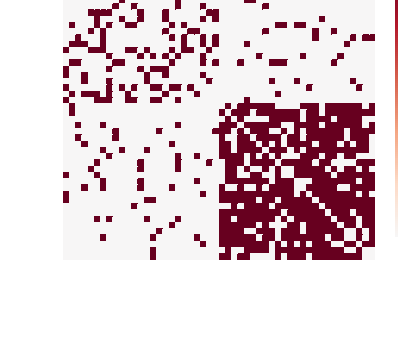

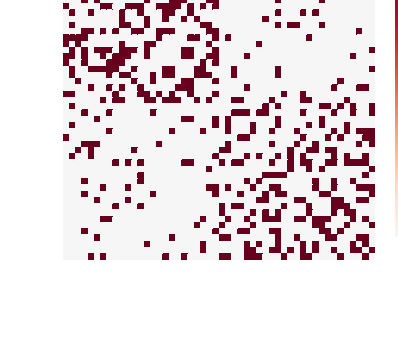

In [4]:
from graspologic.plot import heatmap

heatmap(G1, figsize=(7, 7), title='Visualization of Graph 1')
_ = heatmap(G2, figsize=(7, 7), title='Visualization of Graph 2')

## Embed the two graphs using omnibus embedding

The purpose of embedding graphs is to obtain a Euclidean representation, sometimes called latent positions, of the adjacency matrices. Again, we assume that the probability matrix of a graph is given by $P = XX^T$ and we are trying to estimate $X$. The benefit of omnibus embedding is that the latent positions of all embedded graphs live in the same canonical space, thus eliminating the need to align the results.

We use all of the default parameters. Underneath, the select_dimension algorithm will automatically find the optimal embedding dimension for us. In this example, we get the following estimate,

\begin{align*}
\hat{Z} = 
\begin{bmatrix}
\hat{X_1}\\
\hat{X_2}
\end{bmatrix}
\end{align*}

where the first block, $\hat{X_1}$, are the latent positions of the first graph, and the second block, $\hat{X_2}$, are the latent positions of the second graph.

In [5]:
from graspologic.embed import OmnibusEmbed

embedder = OmnibusEmbed()
Zhat = embedder.fit_transform([G1, G2])

print(Zhat.shape)

(2, 50, 2)


## Visualize the latent positions

Since the two graphs have clear block structures, we should see two "clusters" when we visualize the latent positions. The vertices that form the first block should be close together since they have the same block probabilities, while those that form the second block should be further apart since they have different block probabilities.

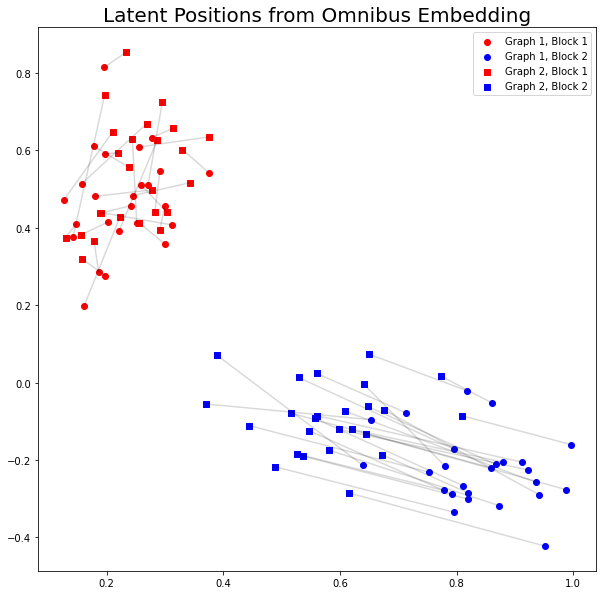

In [6]:
Xhat1 = Zhat[0]
Xhat2 = Zhat[1]

# Plot the points
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(Xhat1[:m, 0], Xhat1[:m, 1], marker='o', c='red', label = 'Graph 1, Block 1')
ax.scatter(Xhat1[m:, 0], Xhat1[m:, 1], marker='o', c='blue', label = 'Graph 1, Block 2')
ax.scatter(Xhat2[:m, 0], Xhat2[:m, 1], marker='s', c='red', label = 'Graph 2, Block 1')
ax.scatter(Xhat2[m:, 0], Xhat2[m:, 1], marker='s', c='blue', label= 'Graph 2, Block 2')
ax.legend()

# Plot lines between matched pairs of points
for i in range(2*m):
    ax.plot([Xhat1[i, 0], Xhat2[i, 0]], [Xhat1[i, 1], Xhat2[i, 1]], 'black', alpha = 0.15)
    
_ = ax.set_title('Latent Positions from Omnibus Embedding', fontsize=20)

## Compare to Adjacency Spectral Embedding

In [7]:
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.plot import pairplot_with_gmm
from sklearn.mixture import GaussianMixture

ase = AdjacencySpectralEmbed()
Xhat3 = ase.fit_transform(G1)
Xhat4 = ase.fit_transform(G2)

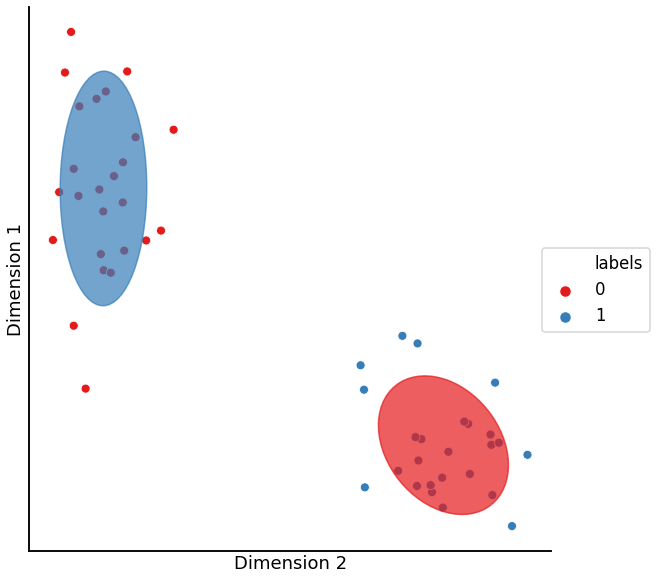

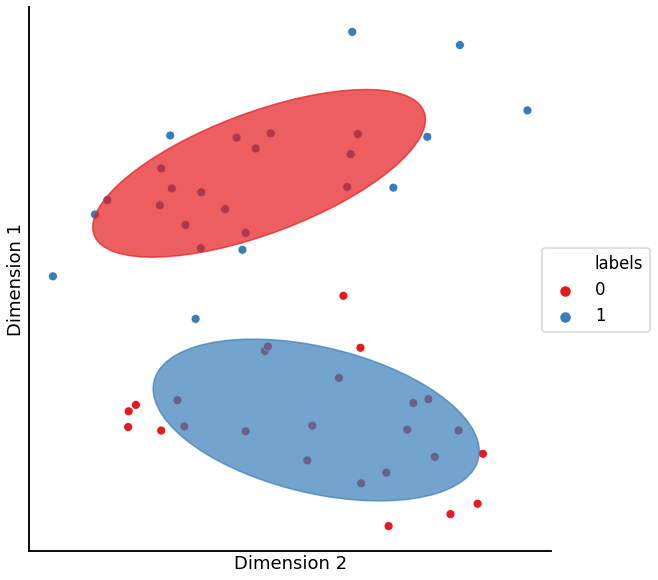

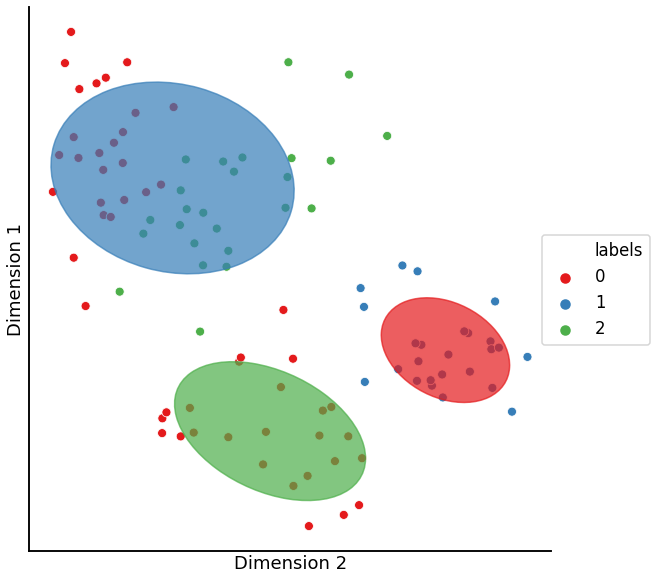

In [9]:
labels_sbm = m * [0] + m * [1]
gmm = GaussianMixture(n_components=2, covariance_type='full').fit(Xhat3)
graph = pairplot_with_gmm(Xhat3, gmm, labels = labels_sbm, figsize=(10, 10))
gmm = GaussianMixture(n_components=2, covariance_type='full').fit(Xhat4)
graph = pairplot_with_gmm(Xhat4, gmm, labels = labels_sbm, figsize=(10, 10))
Xhat = np.concatenate((Xhat3, Xhat4))
labels_sbm = m * [0] + m * [1] + m * [0] + m * [2]
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(Xhat)
graph = pairplot_with_gmm(Xhat, gmm, labels = labels_sbm, figsize=(10, 10))

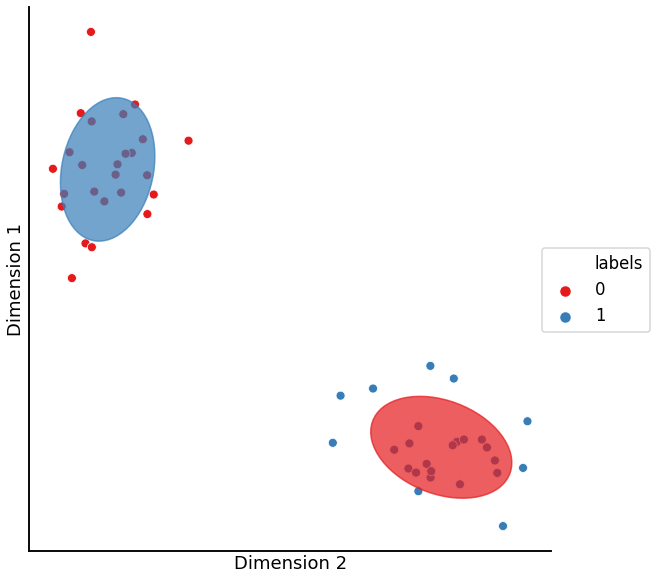

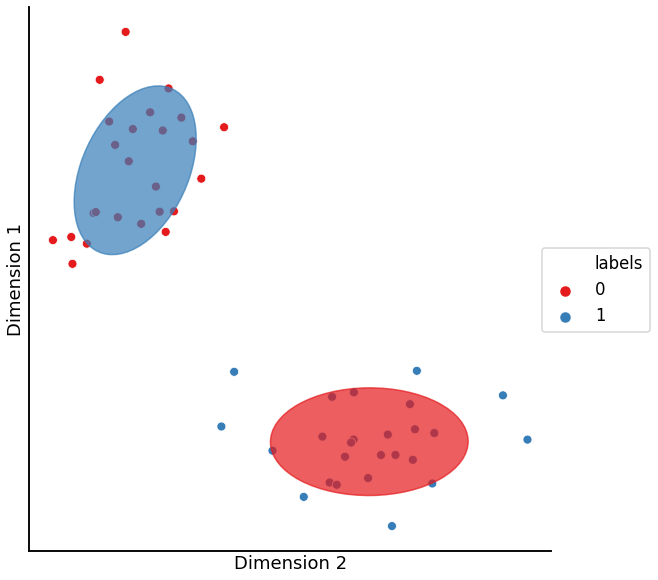

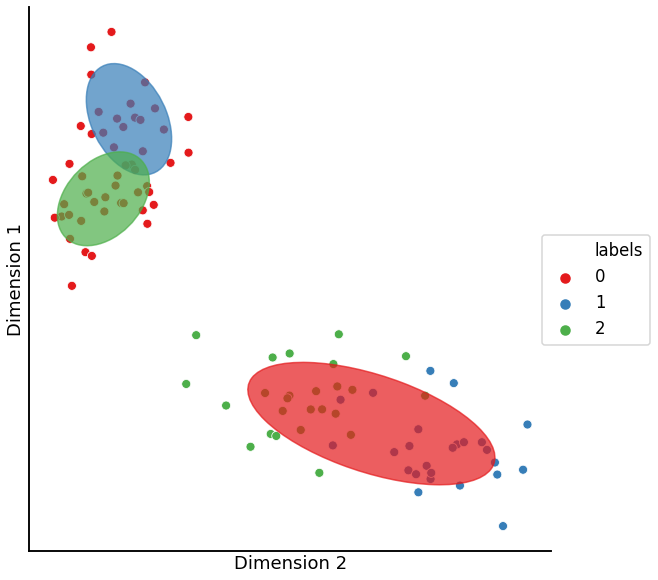

In [10]:
labels_sbm = m * [0] + m * [1]
gmm = GaussianMixture(n_components=2, covariance_type='full').fit(Xhat1)
graph = pairplot_with_gmm(Xhat1, gmm, labels = labels_sbm, figsize=(10, 10))
gmm = GaussianMixture(n_components=2, covariance_type='full').fit(Xhat2)
graph = pairplot_with_gmm(Xhat2, gmm, labels = labels_sbm, figsize=(10, 10))
Xhat = np.concatenate((Xhat1, Xhat2))
labels_sbm = m * [0] + m * [1] + m * [0] + m * [2]
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(Xhat)
graph = pairplot_with_gmm(Xhat, gmm, labels = labels_sbm, figsize=(10, 10))

## Omnibus embedding with graph laplacians

It is also possible to embed multiple graphs simutaneously using their respective laplacian matrices instead of their adjacency matrices.